In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import one_hot
from torch.distributions import Categorical, OneHotCategorical
from matplotlib import pyplot as plt
from unet import UNet
from tqdm import tqdm
import numpy as np
from difflib import SequenceMatcher
from unet import UNet

from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import os
device='cuda' if torch.cuda.is_available() else 'cpu'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
mnist_data = torch.tensor(np.load('data/binary_mnist.npy'))
length = mnist_data.shape[0]
mnist_data = mnist_data.view(length*784)

# torch data
out = torch.zeros(length*784,2, dtype=torch.float32)
out[mnist_data==0, 0]=1
out[mnist_data==1, 1]=1
mnist_data = out.view(length, 28, 28, 2).permute((0,3,1,2))


dataset = TensorDataset(mnist_data) 
dataloader = DataLoader(dataset, batch_size=100, shuffle=True) # create your dataloader

In [3]:
def closest(out):
    return mnist_data[(((mnist_data-out.to('cpu'))**2).sum((1,2,3))).argmin()]

def cust_show(out,**kwargs):
    plt.imshow(out.cpu().detach().numpy(), **kwargs)
    plt.show()


def contains(source, elements):
    out = torch.zeros_like(source, dtype=torch.bool)
    for e in elements:
        out = torch.logical_or(out, source==e)
    return out

In [4]:

class AODM(nn.Module):
    def __init__(self, h=28, w=28, k=2, lr=1e-4):
        super().__init__()
        self.h, self.w, self.k = h, w, k
        self.d = self.h * self.w
        self.unet = UNet(2,2)
        self.lr = lr
        self.loss_hist = torch.zeros(self.d).to(device)
        self.loss_hist_n = torch.zeros(self.d).to(device)

    def forward(self, x):
        x_ = self.unet(x)
        return torch.log_softmax(x_, dim=1)

    def sample_t(self, N):
        return torch.randint(1, self.d + 1, (N, 1, 1), device=device)

    def sample_sigma(self, N):
        return torch.stack([torch.randperm(self.d, device=device).reshape(self.h, self.w) + 1 for _ in range(N)])

    def sigma_with_mask(self, mask):
        # sigma = [1.. mask_pixels || randperm (remaining pixels) ]
        sigma = torch.zeros((1, self.h, self.w), dtype=torch.long, device=device)
        sigma[mask] = torch.arange(mask.sum()) + 1
        sigma[~mask] = torch.randperm(self.d - mask.sum(), device=device) + mask.sum()
        return sigma

    def training_step(self, x):
        N, K, H, W = x.shape
        t = self.sample_t(N)
        
        sigma = self.sample_sigma(N)
        mask = sigma < t
        mask = mask.unsqueeze(1).float()
        x_ = self(x * mask)
        C = Categorical(logits=x_.permute(0, 2, 3, 1))
        l = (1. - mask) * C.log_prob(torch.argmax(x, dim=1)).unsqueeze(1)
        n = 1. / (self.d - t + 1.)


        l = n.flatten() * l.sum(dim=(1, 2, 3))
        
        ### loss:
        with torch.no_grad():
            self.loss_hist[t.flatten().long()-1] += - l
            self.loss_hist_n[t.flatten().long()-1] += 1
        return {'loss': -l.mean(), 'input': x.detach(), 'generated': x_.detach()}

    def training_step_end(self, o):
        self.log('loss', o['loss'])

    def validation_step(self, *args, **kwargs):
        sample = self.sample_one()
        self.sample_quality(sample)
        return {'sample': sample.cpu()}

    def validation_epoch_end(self, outputs):
        self.log('sample_quality', self.sample_quality.compute())

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return [opt]

    def sample_one(self, n=1):
        x = torch.zeros(n, self.k, self.h, self.w, device=device)
        sigma = self.sample_sigma(1)
        for t in range(1, self.d + 1):
            x = self.sample_step(x, t, sigma)
        return x

    def sample_one_seeded(self, x_seed, mask):

        # add masked pixels to seed
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        x[mask] = x_seed[mask]
        sigma = self.sigma_with_mask(mask)

        for t in range(mask.sum(), self.d + 1):
            x = self.sample_step(x, t, sigma)
        return x

    def sample_step(self, x, t, sigma):
        """
        Performs one step of the noise reversal transition function in order sigma at time t
        x: the current state
        t: the current timestep
        sigma: the order
        """
        past, current = sigma < t, sigma == t
        past, current = past.unsqueeze(1).float(), current.unsqueeze(1).float()
        logprobs = self((x * past))
        x_ = OneHotCategorical(logits=logprobs.permute(0, 2, 3, 1)).sample().permute(0, 3, 1, 2)
        x = x * (1 - current) + x_ * current
        return x
    
    def sample_step_cust(self, x, t, sigma):
        past = sigma < t[0]
        current = contains(sigma, t)
        past, current = past.unsqueeze(1).float(), current.unsqueeze(1).float()
        logprobs = self((x * past))
        x_ = OneHotCategorical(logits=logprobs.permute(0, 2, 3, 1)).sample().permute(0, 3, 1, 2)
        x = x * (1 - current) + x_ * current
        return x
    
    def sample_one_cust(self, k=3):
        x = torch.zeros(1, self.k, self.h, self.w, device=device)
        sigma = self.sample_sigma(1)
        for t in range(1, self.d + 1, k):
            x = self.sample_step_cust(x, torch.arange(t, t+k), sigma)
        return x
    
    def sample_one_path(self, path, n=1):
        x = torch.zeros(n, self.k, self.h, self.w, device=device)
        t = 1
        sigma = self.sample_sigma(1)
        for i in tqdm(range(1, len(path))):
            if path[i-1]< path[i]:
                x = self.sample_step_cust(x, torch.arange(path[i-1], path[i]), sigma)
        return x



In [17]:
model = AODM().to(device)
#model.eval()
#out = model.sample_one()
model = torch.load('bin_mnist2.pt')

opt = model.configure_optimizers()[0]
L=[]

In [18]:
model.lr = 1e-4
opt = model.configure_optimizers()[0]

In [19]:
if False:
    for i in tqdm(range(40)):
       # model.eval()
        #out = model.sample_one()
        #plt.imsave('figs/epoch_{}.png'.format(i), out[0,1].cpu().detach().numpy())
        if i%2==0:
            print('saving model')
            torch.save(model, 'bin_mnist3.pt')
            print('model saved')

        model.train()
        l=0
        for idx, batch in enumerate(dataloader):
            x = batch[0].to(device)
            opt.zero_grad()
            out = model.training_step(x)
            loss = out['loss']
            l+=loss.item()
            loss.backward()
            opt.step()
        L.append(l)
        plt.plot(L)
        plt.show()


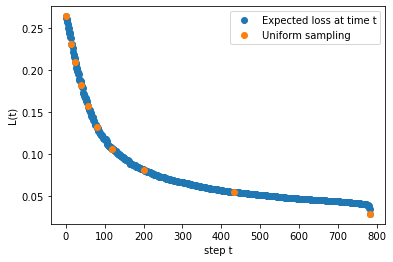

In [20]:
loss_array = np.load('bin_loss.npy')


def divide_array(arr, n):
    steps = (arr[0]-arr[-1])/(n-1)
    L = [0]
    
    for i in range(1, n-1):
        mask = (arr < arr[0]-i*steps)
        ind = mask.argmax()
        if ind <= L[-1]:
            ind = L[-1]+1
            if ind >= len(arr):
                ind = len(arr)-1
        L.append(ind)
    L.append(len(arr)-1)
    return L

x = divide_array(loss_array, 10)
y = loss_array[x]
plt.plot(loss_array, 'o', label='Expected loss at time t')
plt.plot(x,y, 'o', label='Uniform sampling')
plt.xlabel('step t')
plt.ylabel('L(t)')
plt.legend()
#plt.savefig('figs/uniform_samplingb.png')
plt.show()


# Evaluate model

In [35]:
model.eval()
nstep=400
x = divide_array(loss_array, nstep)
out = model.sample_one_path(x, 10)

100%|████████████████████████████████████████| 399/399 [00:03<00:00, 105.64it/s]


      Generated Image    Closest Neighbour


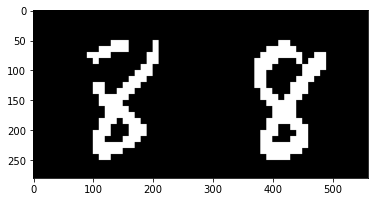

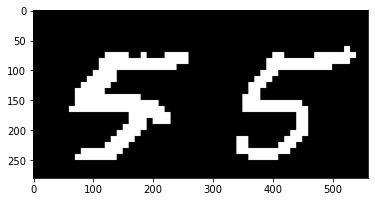

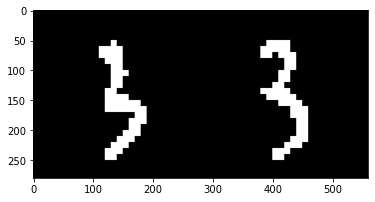

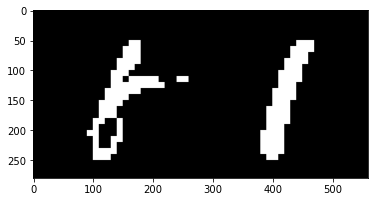

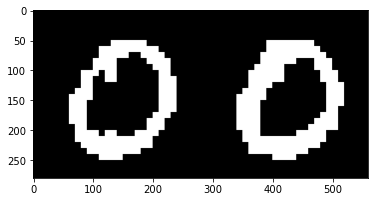

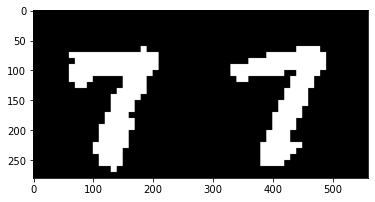

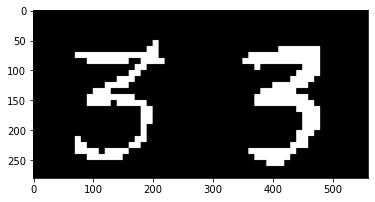

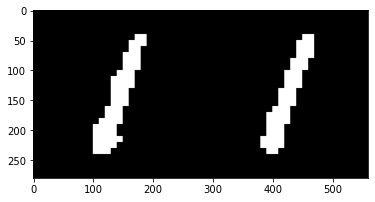

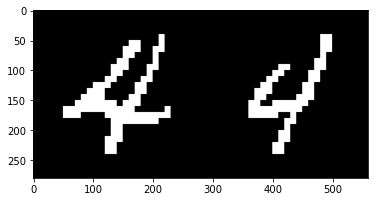

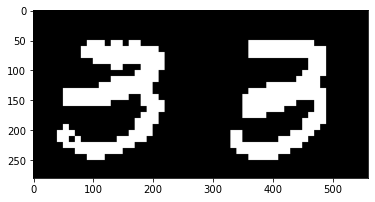

In [41]:
print('      Generated Image    Closest Neighbour')
for i in range(out.shape[0]):
    gen_im = out[i,1].cpu().detach().numpy()
    ref_im = closest(out[i])[1].cpu().detach().numpy()    
    gen_im = Image.fromarray(gen_im>0.5)
    gen_im = gen_im.resize((280,280), Image.NEAREST)
   
    ref_im = Image.fromarray(ref_im>0.5)
    ref_im = ref_im.resize((280,280), Image.NEAREST)
    
    CURRENT_im = np.concatenate([gen_im, ref_im], axis=1)
    
    plt.imshow(CURRENT_im, cmap='gray')
    plt.show()

# Save dataset

In [28]:
model.eval()
out = model.sample_one(200)

In [30]:
for i in range(out.shape[0]):
    gen_im = out[i,1].cpu().detach().numpy()
    plt.imsave('figs/mnist_gen/{}.png'.format(i), gen_im, cmap='gray')